In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import pandas as pd


# Ensure the device is set correctly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class HazyDataset(Dataset):
    def __init__(self, hazy_files, gt_files, transform=None):
        self.hazy_files = hazy_files
        self.gt_files = gt_files
        self.transform = transform

    def __len__(self):
        return len(self.hazy_files)

    def __getitem__(self, idx):
        hazy_img_path = self.hazy_files[idx]
        gt_img_path = self.gt_files[idx]

        hazy_image = Image.open(hazy_img_path).convert('RGB')
        gt_image = Image.open(gt_img_path).convert('RGB')

        if self.transform:
            hazy_image = self.transform(hazy_image)
            gt_image = self.transform(gt_image)

        return hazy_image, gt_image
from torch.utils.data import DataLoader


import os

hazy_dir = "/kaggle/input/hazing-images-dataset-cvpr-2019/hazy"
hazy_files = sorted([os.path.join(hazy_dir, f) for f in os.listdir(hazy_dir)])


gt_dir = "/kaggle/input/hazing-images-dataset-cvpr-2019/GT"
gt_files = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir)])




# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create dataset and dataloader
dataset = HazyDataset(hazy_files, gt_files, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

class DehazingResNet18(nn.Module):
    def __init__(self, num_output_channels=3):
        super(DehazingResNet18, self).__init__()
        
        # Load pre-trained ResNet18
        self.resnet18 = models.resnet18(pretrained=True)
        
        # Remove fully connected layer
        self.resnet18 = nn.Sequential(*list(self.resnet18.children())[:-2])
        
        # Additional convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(32, num_output_channels, kernel_size=3, padding=1)  # Added this line
        
        # Batch Normalization layers
        self.bn1 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(32)  # Added this line
        
        # Upsampling layers
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upsample4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.upsample5 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Activation function
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        # Pass through ResNet18
        x = self.resnet18(x)
        
        # Additional layers for dehazing
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.upsample1(x)
        
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.upsample2(x)
        
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.upsample3(x)
        
        x = self.relu(self.bn4(self.conv4(x)))  # Added this line
        x = self.upsample4(x)  # Moved this line up
        
        x = self.conv5(x)
        x = self.upsample5(x)
        
        return x

# Example usage:
model = DehazingResNet18(num_output_channels=3)
input_tensor = torch.randn(1, 3, 224, 224)  # Batch size 1, 3 color channels, 224x224 image
output = model(input_tensor)
print(output.shape)  # Should print torch.Size([1, 3, 224, 224])


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 49.9MB/s]


torch.Size([1, 3, 224, 224])


In [4]:

model = DehazingResNet18().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    for i, data in enumerate(dataloader, 0):
        hazy_image, gt_image = data
        hazy_image = hazy_image.to(device)
        gt_image = gt_image.to(device)

        # Forward pass
        outputs = model(hazy_image)
        loss = criterion(outputs, gt_image)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], Loss: {loss.item():.4f}')

print("Training complete")

Epoch [0/1000], Step [0/4], Loss: 0.4490
Epoch [1/1000], Step [0/4], Loss: 0.2199
Epoch [2/1000], Step [0/4], Loss: 0.1815
Epoch [3/1000], Step [0/4], Loss: 0.1866
Epoch [4/1000], Step [0/4], Loss: 0.1869
Epoch [5/1000], Step [0/4], Loss: 0.1493
Epoch [6/1000], Step [0/4], Loss: 0.1455
Epoch [7/1000], Step [0/4], Loss: 0.1426
Epoch [8/1000], Step [0/4], Loss: 0.1671
Epoch [9/1000], Step [0/4], Loss: 0.1249
Epoch [10/1000], Step [0/4], Loss: 0.1244
Epoch [11/1000], Step [0/4], Loss: 0.1262
Epoch [12/1000], Step [0/4], Loss: 0.1356
Epoch [13/1000], Step [0/4], Loss: 0.1207
Epoch [14/1000], Step [0/4], Loss: 0.1174
Epoch [15/1000], Step [0/4], Loss: 0.1188
Epoch [16/1000], Step [0/4], Loss: 0.1425
Epoch [17/1000], Step [0/4], Loss: 0.1279
Epoch [18/1000], Step [0/4], Loss: 0.1053
Epoch [19/1000], Step [0/4], Loss: 0.1331
Epoch [20/1000], Step [0/4], Loss: 0.1151
Epoch [21/1000], Step [0/4], Loss: 0.0988
Epoch [22/1000], Step [0/4], Loss: 0.1146
Epoch [23/1000], Step [0/4], Loss: 0.1030
Ep

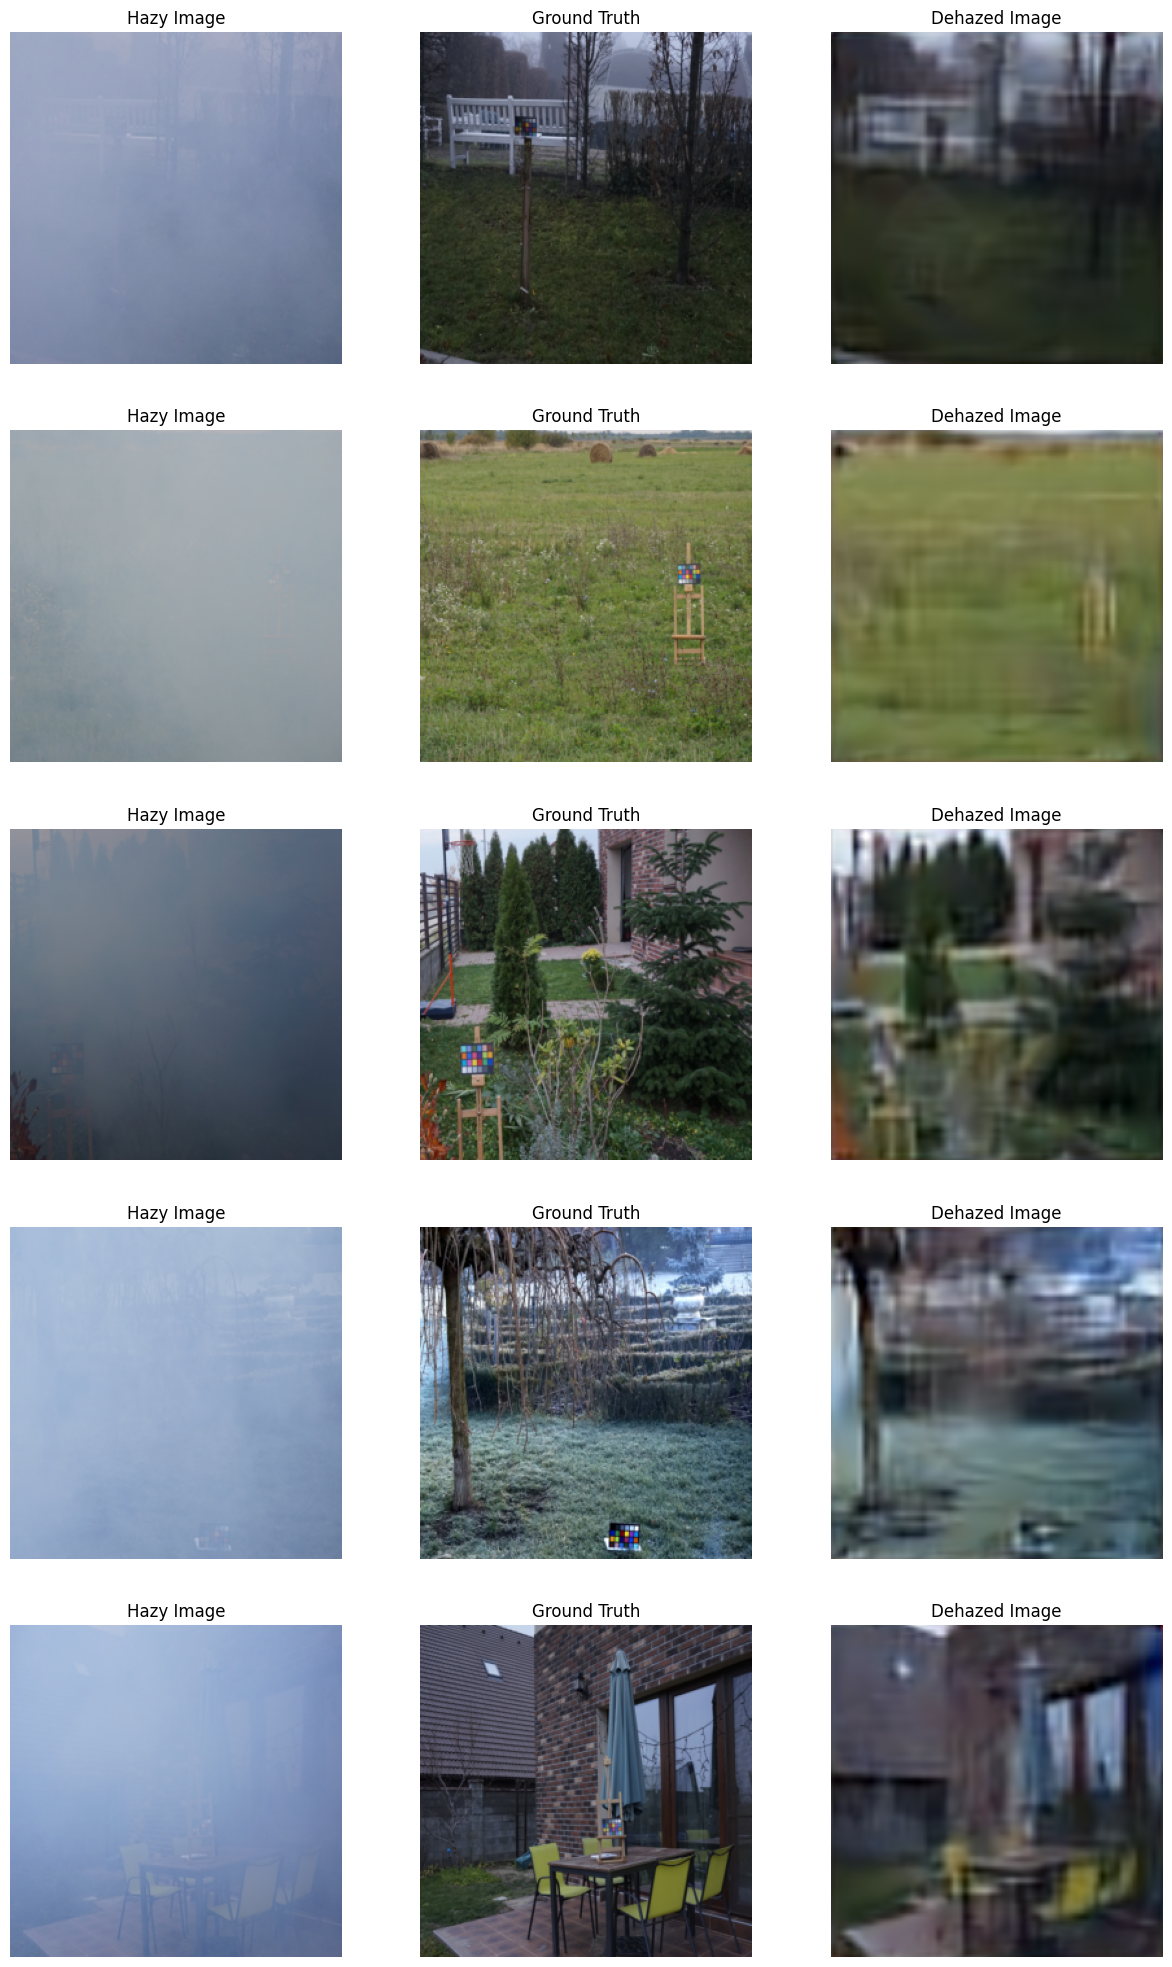

In [5]:
# Function to display images
def display_images(hazy_images, gt_images, dehazed_images):
    fig, axes = plt.subplots(len(hazy_images), 3, figsize=(15, 5 * len(hazy_images)))

    for i in range(len(hazy_images)):
        axes[i, 0].imshow(hazy_images[i])
        axes[i, 0].set_title('Hazy Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(gt_images[i])
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(dehazed_images[i])
        axes[i, 2].set_title('Dehazed Image')
        axes[i, 2].axis('off')

    plt.show()


# Collect some sample images to display
eval_dataset = dataset
hazy_sample, gt_sample, dehazed_sample = [], [], []
model.eval()
with torch.no_grad():
    for i in range(5):  # Show 5 samples
        hazy_image, gt_image = eval_dataset[i]
        hazy_sample.append(hazy_image.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Denormalize for display
        gt_sample.append(gt_image.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Denormalize for display

        hazy_image = hazy_image.unsqueeze(0).to(device)
        dehazed_image = model(hazy_image).squeeze(0).cpu().permute(1, 2, 0).numpy()
        dehazed_sample.append(dehazed_image * 0.5 + 0.5)  # Denormalize for display


display_images(hazy_sample, gt_sample, dehazed_sample)

In [6]:
torch.save(model.state_dict(), '/kaggle/working/Dehazing.pth')

In [7]:
model.load_state_dict(torch.load('/kaggle/working/Dehazing.pth'))

<All keys matched successfully>

In [8]:
model.eval()

DehazingResNet18(
  (resnet18): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

Average PSNR: 22.65140214134751
Average SSIM: 0.5940959518606013


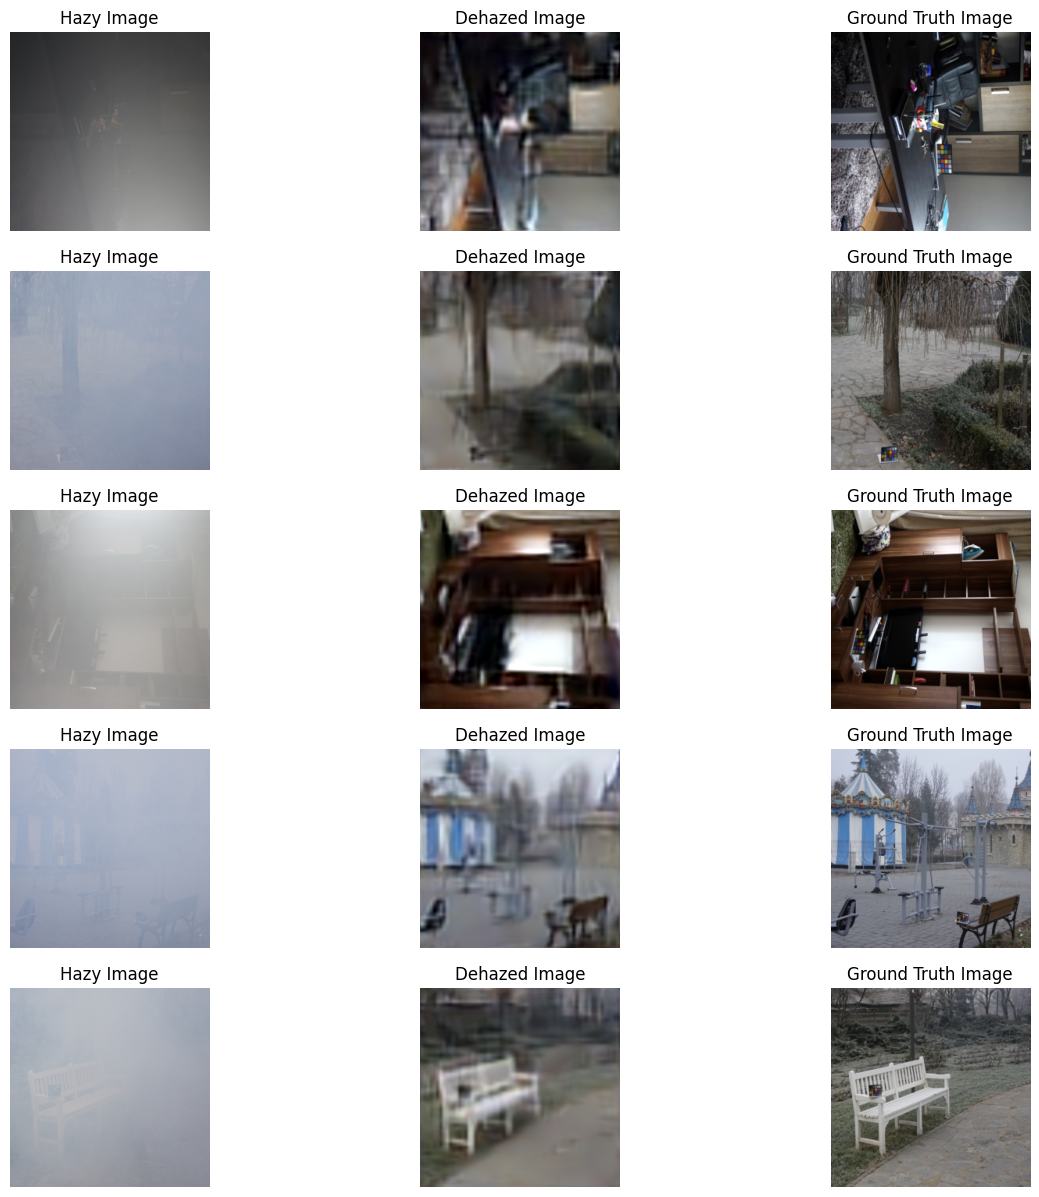

In [9]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# Function to denormalize and convert tensor to image
def tensor_to_image(tensor):
    image = tensor.cpu().detach().numpy().transpose(1, 2, 0)  # Change dimensions to HWC
    image = (image + 1) / 2  # Denormalize
    image = np.clip(image, 0, 1)  # Ensure values are within [0, 1]
    return image
# Arrays to store images and metrics
hazy_images_list = []
dehazed_images_list = []
gt_images_list = []
psnr_values = []
ssim_values = []

# Process all images in the dataloader
for hazy_images, gt_images in dataloader:
    hazy_images = hazy_images.to(device)
    gt_images = gt_images.to(device)
    with torch.no_grad():
        dehazed_images = model(hazy_images)

    # Convert tensors to images and store them
    for i in range(hazy_images.size(0)):
        hazy_image = tensor_to_image(hazy_images[i])
        dehazed_image = tensor_to_image(dehazed_images[i])
        gt_image = tensor_to_image(gt_images[i])

        hazy_images_list.append(hazy_image)
        dehazed_images_list.append(dehazed_image)
        gt_images_list.append(gt_image)

        # Calculate PSNR and SSIM
        psnr_value = psnr(gt_image, dehazed_image, data_range=dehazed_image.max() - dehazed_image.min())
        ssim_value=ssim(gt_image, dehazed_image, win_size=11,data_range=dehazed_image.max() - dehazed_image.min(), channel_axis=-1)

        psnr_values.append(psnr_value)
        ssim_values.append(ssim_value)

# Print average PSNR and SSIM
avg_psnr = sum(psnr_values) / len(psnr_values)
avg_ssim = sum(ssim_values) / len(ssim_values)

print(f'Average PSNR: {avg_psnr}')
print(f'Average SSIM: {avg_ssim}')

# Display a few images (optional)
fig, axs = plt.subplots(5, 3, figsize=(15, 15))
for i in range(5):
    axs[i, 0].imshow(hazy_images_list[i])
    axs[i, 0].set_title('Hazy Image')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(dehazed_images_list[i])
    axs[i, 1].set_title('Dehazed Image')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(gt_images_list[i])
    axs[i, 2].set_title('Ground Truth Image')
    axs[i, 2].axis('off')

plt.show()


In [10]:
import pandas as pd
Error=pd.DataFrame({'psnr_values':psnr_values,'ssim_values':ssim_values})

In [11]:
Error.describe()

,psnr_values,ssim_values
count,55.000000,55.000000
mean,22.651402,0.594096
std,1.257418,0.107894
min,19.821967,0.415605
25%,21.720374,0.497339
50%,22.720444,0.580368
75%,23.546928,0.683226
max,25.070539,0.793232


In [12]:
Error.to_csv('/kaggle/working/evaluation_results.csv', index=False)